In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,f1_score,confusion_matrix,accuracy_score

In [2]:
email_df=pd.read_csv('emails_dataset.csv')

In [3]:
email_df.head(10)

,subject,from,to,date,body,label
0,"ec 335 , ei 305 and smi 23 revision effective ...",NaN,NaN,NaN,p / l )\n- - - - - - - - - - - - - - - - - - -...,0
1,Re: [Razor-users] Razor with sendmail,Theo Van Dinter <felicity@kluge.net>,Sven Willenberger <sven@dmv.com>,"Fri, 23 Aug 2002 16:26:18 -0400","On Fri, Aug 23, 2002 at 04:17:55PM -0400, Sven...",0
2,e - commerce & continental europe,NaN,NaN,NaN,"hi sven ,\nthanks a lot for your note - i thin...",0
3,Play by Play: Effective Memory Management,guardian <rssfeeds@example.com>,yyyy@example.com,"Thu, 26 Sep 2002 15:29:31 -0000","URL: http://www.newsisfree.com/click/-6,650303...",0
4,Re: [SAtalk] O.T. Habeus -- Why?,bob@proulx.com,Spamassassin-Talk <spamassassin-talk@example.s...,"Thu, 29 Aug 2002 10:32:57 -0600",Justin Mason <jm@jmason.org> [2002-08-29 17:00...,0
5,Robbie Williams signs £80m deal,guardian <rssfeeds@example.com>,yyyy@example.com,"Thu, 03 Oct 2002 08:02:12 -0000","URL: http://www.newsisfree.com/click/215,8,215...",0
6,info missing medical detaiis found 24 th march,NaN,NaN,NaN,stop\nthe protesters were also calling for an ...,1
7,RE: [ILUG] slashdot EW Dijkstra humor,Kenn Humborg <kenn@bluetree.ie>,"Nick Murtagh <nickm@go2.ie>, ilug@linux.ie","Mon, 12 Aug 2002 19:56:23 +0100",> > If you're using a break or similar constru...,0
8,[ILUG] Create a PAYCHECK with your COMPUTER an...,Hugh5546x73@bigfoot.com,ilug@linux.ie,"Tue, 24 Sep 2002 01:31:44 +1200",Hi -\n\n( http://club.4tfox.com )\n\nYou get e...,1
9,Re: It's a small world,Luis Villa <louie@ximian.com>,Jesse <jesse@fsck.com>,"Thu, 15 Aug 2002 18:01:06 -0400","On Thu, 2002-08-15 at 17:53, Jesse wrote:\n> \...",0


In [4]:
email_df['label'].unique()

array([0, 1], dtype=int64)

In [5]:
email_df.shape

(16933, 6)

In [6]:
email_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16933 entries, 0 to 16932
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  16849 non-null  object
 1   from     9347 non-null   object
 2   to       8978 non-null   object
 3   date     9348 non-null   object
 4   body     16828 non-null  object
 5   label    16933 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 793.9+ KB


In [7]:
email_df.isnull().sum()

subject      84
from       7586
to         7955
date       7585
body        105
label         0
dtype: int64

In [8]:
email_df = email_df.dropna(subset=['body','label','subject'])

In [9]:
email_df.isnull().sum()

subject       0
from       7460
to         7829
date       7459
body          0
label         0
dtype: int64

In [10]:
email_df['label'].value_counts()

0    11401
1     5353
Name: label, dtype: int64

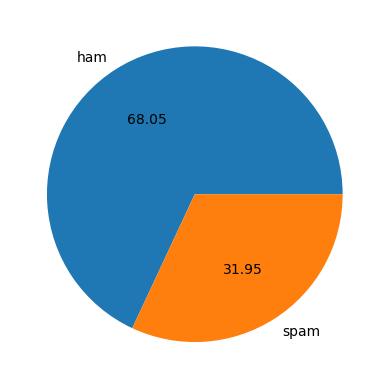

<Figure size 2000x2000 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
plt.pie(email_df['label'].value_counts(), labels = ['ham','spam'],autopct="%0.2f")
plt.figure(figsize=(20,20))
plt.show()

In [12]:
X = email_df.drop(['from','to','date'],axis=1)
y = email_df['label']

In [13]:
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# Ensure NLTK resources are downloaded
import nltk
try:
    nltk.data.find('corpora/stopwords')
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')

# Load stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    Enhanced preprocessing function for email text classification
    """
    try:
        # Handle None or non-string inputs
        if not isinstance(text, str):
            text = str(text) if text is not None else ""
            
        # Convert to lowercase
        text = text.lower()
        
        # Extract text from HTML (if present)
        if '<' in text and '>' in text:
            try:
                text = BeautifulSoup(text, "html.parser").get_text()
            except Exception:
                # If BeautifulSoup fails, try simple regex-based HTML tag removal
                text = re.sub(r'<[^>]+>', ' ', text)
        
        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)
        
        # Remove URLs
        text = re.sub(r'http\S+|www\.\S+', '', text)
        
        # Remove special characters but preserve numbers as they might indicate prices/offers
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Filter short words, stopwords and lemmatize
        tokens = [
            lemmatizer.lemmatize(word) for word in tokens 
            if word not in stop_words and len(word) > 1
        ]
        
        # Join tokens back into text
        return ' '.join(tokens)
    
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        # Return empty string in case of errors, to avoid breaking the pipeline
        return ""

subject_vectorizer = TfidfVectorizer(
        max_features=1000,  # Fewer features for subject as it's shorter
        ngram_range=(1, 2),
        min_df=2
    )
    
# Enhanced vectorizer with n-grams
body_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # Include both unigrams and bigrams
    min_df=2,            # Ignore terms that appear in less than 2 documents
    max_df=0.95,         # Ignore terms that appear in more than 95% of documents
    strip_accents='unicode',
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True    # Apply sublinear tf scaling (1 + log(tf))
)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
email_df['preprocessed_subject'] = email_df['subject'].apply(preprocess_text)
email_df['preprocessed_body'] = email_df['body'].apply(preprocess_text)

In [15]:
X_subject = subject_vectorizer.fit_transform(email_df['preprocessed_subject'])
X_body = body_vectorizer.fit_transform(email_df['preprocessed_body'])

In [16]:
X_combined = np.hstack((X_subject.toarray(), X_body.toarray()))

In [17]:
email_df.sample(10)

,subject,from,to,date,body,label,preprocessed_subject,preprocessed_body
15695,Re: My brain hurts,"""Joseph S. Barrera III"" <joe@barrera.org>",Robert Harley <harley@corton.inria.fr>,"Tue, 23 Jul 2002 17:47:35 -0700","Okay, here's a joke I *just* made up while I w...",0,brain hurt,okay here joke made driving car home one day p...
1667,[zzzzteana] Hot rock,Tim Chapman <timc@2ubh.com>,zzzzteana <zzzzteana@yahoogroups.com>,"Wed, 28 Aug 2002 13:03:39 +0100",http://yorkshirepost.co.uk/scripts/editorial2....,0,zzzzteana hot rock,close encounter burnt kind came outer space te...
4360,Re: boycotting yahoo,Rodent of Unusual Size <Ken.Coar@Golux.Com>,Flatware or Road Kill? <FoRK@xent.com>,"Wed, 18 Sep 2002 07:13:36 -0400",CDale wrote:\n> \n> I was wondering if anyone ...,0,boycotting yahoo,cdale wrote wondering anyone know alternative ...
3349,feb 01 prod : sale to teco gas processing,NaN,NaN,NaN,sale\ndeal # 235670\nexpired 12 / 00\njulie -\...,0,feb 01 prod sale teco gas processing,sale deal 235670 expired 12 00 julie deal expi...
2689,Re: [dgc.chat] free?,"""R. A. Hettinga"" <rah@shipwright.com>","cypherpunks@lne.com, fork@spamassassin.taint.o...","Sun, 11 Aug 2002 12:31:56 -0400","\n--- begin forwarded text\n\n\nDate: Sun, 11 ...",0,dgcchat free,begin forwarded text date sun 11 aug 2002 0333...
16699,Webex Endeavors,Gregory Alan Bolcer <gbolcer@endeavors.com>,FoRK <fork@example.com>,"Thu, 19 Sep 2002 06:34:43 -0700",We have a partnership with Webex. We use thei...,0,webex endeavor,partnership webex use serivce crossfirewall ap...
15036,Re: [ILUG] Dell GX260 V Redhat 7.3,Rick Moen <rick@linuxmafia.com>,ilug@linux.ie,"Mon, 05 Aug 2002 16:04:12 -0700",Quoting Declan Houlihan (deccy@csn.ul.ie):\n\n...,0,ilug dell gx260 redhat 73,quoting declan houlihan actually investigating...
3374,AOL Keyword: Fraud Probe,Media Unspun <guterman@mediaunspun.imakenews.net>,zzz-unspun@spamassassin.taint.org,"Thu, 26 Sep 2002 09:28:03 -0400","To view this newsletter in full-color, visit:\...",0,aol keyword fraud probe,view newsletter fullcolor visit medium unspun ...
11521,fw : executed amendments update,NaN,NaN,NaN,- - - - - original message - - - - -\nfrom : j...,0,fw executed amendment update,original message joyner tamera sent friday oct...
13736,RE: [ILUG] Redhat 8.0,"""HAMILTON,DAVID (HP-Ireland,ex2)"" <david_hamil...","""'ilug@linux.ie'"" <ilug@linux.ie>","Mon, 02 Sep 2002 15:46:58 +0100",I just saw the ISOs on an internal server here...,0,ilug redhat 80,saw isos internal server tempted original mess...


In [18]:
email_df['num_characters_body'] = email_df['preprocessed_body'].apply(len)
email_df['num_characters_subject'] = email_df['preprocessed_subject'].apply(len)

In [19]:
import nltk
email_df['num_words_body'] = email_df['preprocessed_body'].apply(lambda x:len(nltk.word_tokenize(x)))
email_df['num_words_subject'] = email_df['preprocessed_subject'].apply(lambda x:len(nltk.word_tokenize(x)))

In [20]:
email_df.sample(10)

,subject,from,to,date,body,label,preprocessed_subject,preprocessed_body,num_characters_body,num_characters_subject,num_words_body,num_words_subject
12099,"all graphics software available , cheap oem ve...",NaN,NaN,NaN,"good morning ,\nwe we offer latest oem package...",1,graphic software available cheap oem version,good morning offer latest oem package graphic ...,689,44,110,6
8085,Re: [zzzzteana] Moon over ocean,Bill Jacobs <billjac@earthlink.net>,zzzzteana@yahoogroups.com,"Tue, 27 Aug 2002 14:42:46 -0400",David asked:\n> My wife noticed something odd....,0,zzzzteana moon ocean,david asked wife noticed something odd nearlyf...,790,20,122,3
14495,re : producer connects on the 215 contract - a...,NaN,NaN,NaN,thanks for the info heidi . it ' s always good...,0,producer connects 215 contract april,thanks info heidi always good second pair eye ...,186,36,31,5
10769,do you really wanna pay for tv ?,NaN,NaN,NaN,"good day to you sir ,\nget ppv sports , movies...",1,really wan na pay tv,good day sir get ppv sport movie adult channel...,258,20,44,5
4969,lower your company phone bill every month !,NaN,NaN,NaN,unlimited web conferencing\nsubscribe to the w...,1,lower company phone bill every month,unlimited web conferencing subscribe web confe...,1015,36,143,6
14064,georgeanne just told me that the lehman and je...,NaN,NaN,NaN,"other .\nregards ,\neugenio",0,georgeanne told lehman jedi swap hedge,regard eugenio,14,38,2,6
16366,softs in london,NaN,NaN,NaN,"vince ,\nwith regard to the softs curves devel...",0,softs london,vince regard softs curve development communica...,650,12,88,2
10954,The database that Bill Gates doesnt want you t...,Francine Mogri <mrhealth@btamail.net.cn>,abidkazi@hotmail.com,"Tue, 23 Jul 2002 08:23:03 -0700",<HTML>\n<HEAD>\n<TITLE></TITLE>\n</HEAD>\n<BOD...,1,database bill gate doesnt want know,struggling m access manage data dont worry bil...,874,35,117,6
2782,Re: Ringing bell on other computer,Dag Nygren <dag@newtech.fi>,Chris Garrigues <cwg-dated-1034518125.8385c0@D...,"Tue, 08 Oct 2002 21:56:52 +0300",\n> > > \n> > > Dag> but when procmail runs ...,0,ringing bell computer,dag procmail run doesnt presumably dag doesnt ...,731,21,106,3
4128,Re: Ouch...,Eirikur Hallgrimsson <eh@mad.scientist.com>,FoRK <FoRK@xent.com>,"Thu, 05 Sep 2002 14:32:42 -0400","On Wednesday 04 September 2002 10:59 pm, CDale...",0,ouch,wednesday 04 september 2002 1059 pm cdale wrot...,602,4,80,1


In [21]:
email_df['num_sentences_body'] = email_df['preprocessed_body'].apply(lambda x:len(nltk.sent_tokenize(x)))
email_df['num_sentences_subject'] = email_df['preprocessed_subject'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [22]:
email_df[['num_characters_subject','num_characters_body','num_words_subject','num_words_body','num_sentences_subject','num_sentences_body']].describe()

,num_characters_subject,num_characters_body,num_words_subject,num_words_body,num_sentences_subject,num_sentences_body
count,16754.000000,16754.000000,16754.000000,16754.000000,16754.000000,16754.000000
mean,26.469560,1061.516295,4.067566,150.292467,0.989197,0.997732
std,16.768416,3017.595300,2.493608,374.986291,0.103379,0.047572
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,242.000000,3.000000,36.000000,1.000000,1.000000
50%,25.000000,507.000000,4.000000,75.000000,1.000000,1.000000
75%,35.000000,1008.000000,5.000000,148.000000,1.000000,1.000000
max,872.000000,123679.000000,133.000000,17631.000000,1.000000,1.000000


In [23]:
email_df[email_df['label'] == 0][['num_characters_subject','num_characters_body','num_words_subject','num_words_body','num_sentences_subject','num_sentences_body']].describe()

,num_characters_subject,num_characters_body,num_words_subject,num_words_body,num_sentences_subject,num_sentences_body
count,11401.000000,11401.000000,11401.000000,11401.000000,11401.000000,11401.000000
mean,26.338742,1049.528550,4.018683,151.807561,0.991931,0.999649
std,16.918187,2973.772589,2.509613,413.934771,0.089471,0.018728
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,234.000000,2.000000,35.000000,1.000000,1.000000
50%,24.000000,504.000000,4.000000,75.000000,1.000000,1.000000
75%,34.000000,996.000000,5.000000,147.000000,1.000000,1.000000
max,872.000000,123679.000000,133.000000,17631.000000,1.000000,1.000000


In [24]:
email_df[email_df['label'] == 1][['num_characters_subject','num_characters_body','num_words_subject','num_words_body','num_sentences_subject','num_sentences_body']].describe()

,num_characters_subject,num_characters_body,num_words_subject,num_words_body,num_sentences_subject,num_sentences_body
count,5353.000000,5353.000000,5353.000000,5353.000000,5353.000000,5353.000000
mean,26.748179,1087.048197,4.171679,147.065571,0.983374,0.993648
std,16.442979,3109.000634,2.456164,274.180981,0.127878,0.079451
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,257.000000,3.000000,38.000000,1.000000,1.000000
50%,25.000000,516.000000,4.000000,75.000000,1.000000,1.000000
75%,35.000000,1055.000000,5.000000,152.000000,1.000000,1.000000
max,476.000000,120669.000000,68.000000,6480.000000,1.000000,1.000000


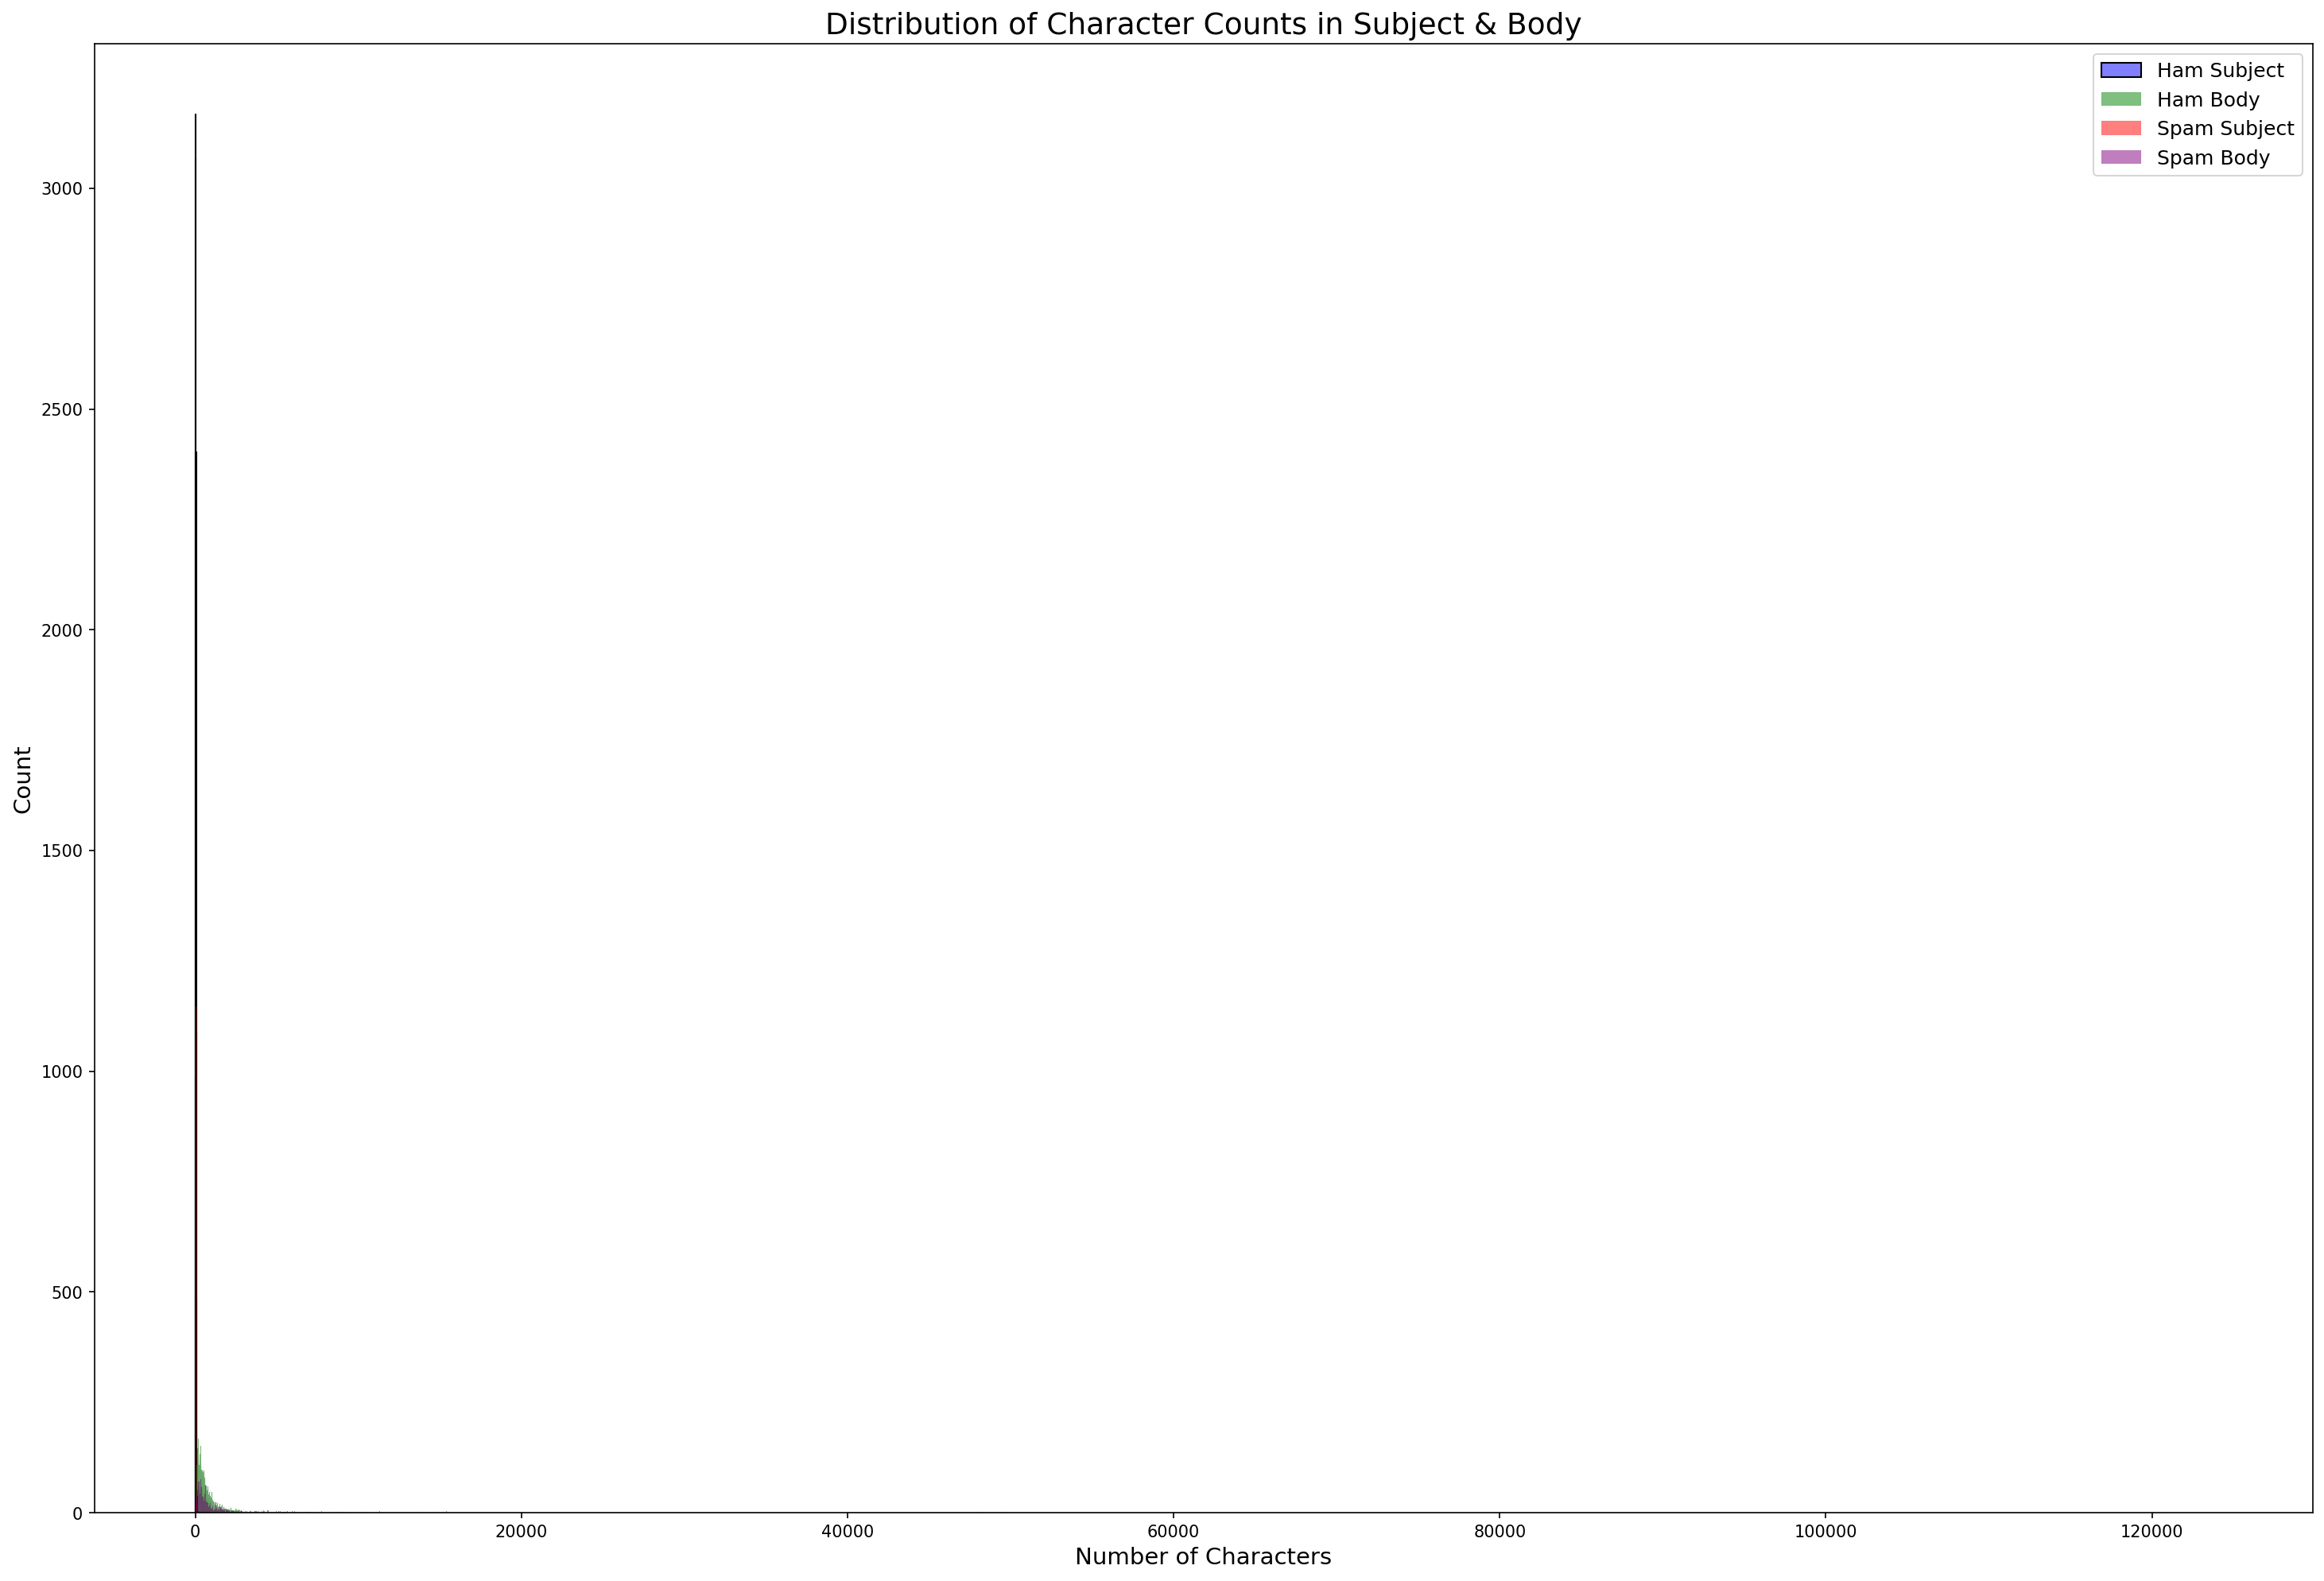

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 16),dpi=150)

# Ham (label = 0) - Subject & Body
sns.histplot(email_df[email_df['label'] == 0]['num_characters_subject'], 
             color='blue', alpha=0.5, binwidth=10, label="Ham Subject")
sns.histplot(email_df[email_df['label'] == 0]['num_characters_body'], 
             color='green', alpha=0.5, binwidth=10, label="Ham Body")

# Spam (label = 1) - Subject & Body
sns.histplot(email_df[email_df['label'] == 1]['num_characters_subject'], 
             color='red', alpha=0.5, binwidth=10, label="Spam Subject")
sns.histplot(email_df[email_df['label'] == 1]['num_characters_body'], 
             color='purple', alpha=0.5, binwidth=10, label="Spam Body")

# Titles & Labels
plt.title("Distribution of Character Counts in Subject & Body", fontsize=18)
plt.xlabel("Number of Characters", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(fontsize=12)  # Add legend for clarity

plt.show()


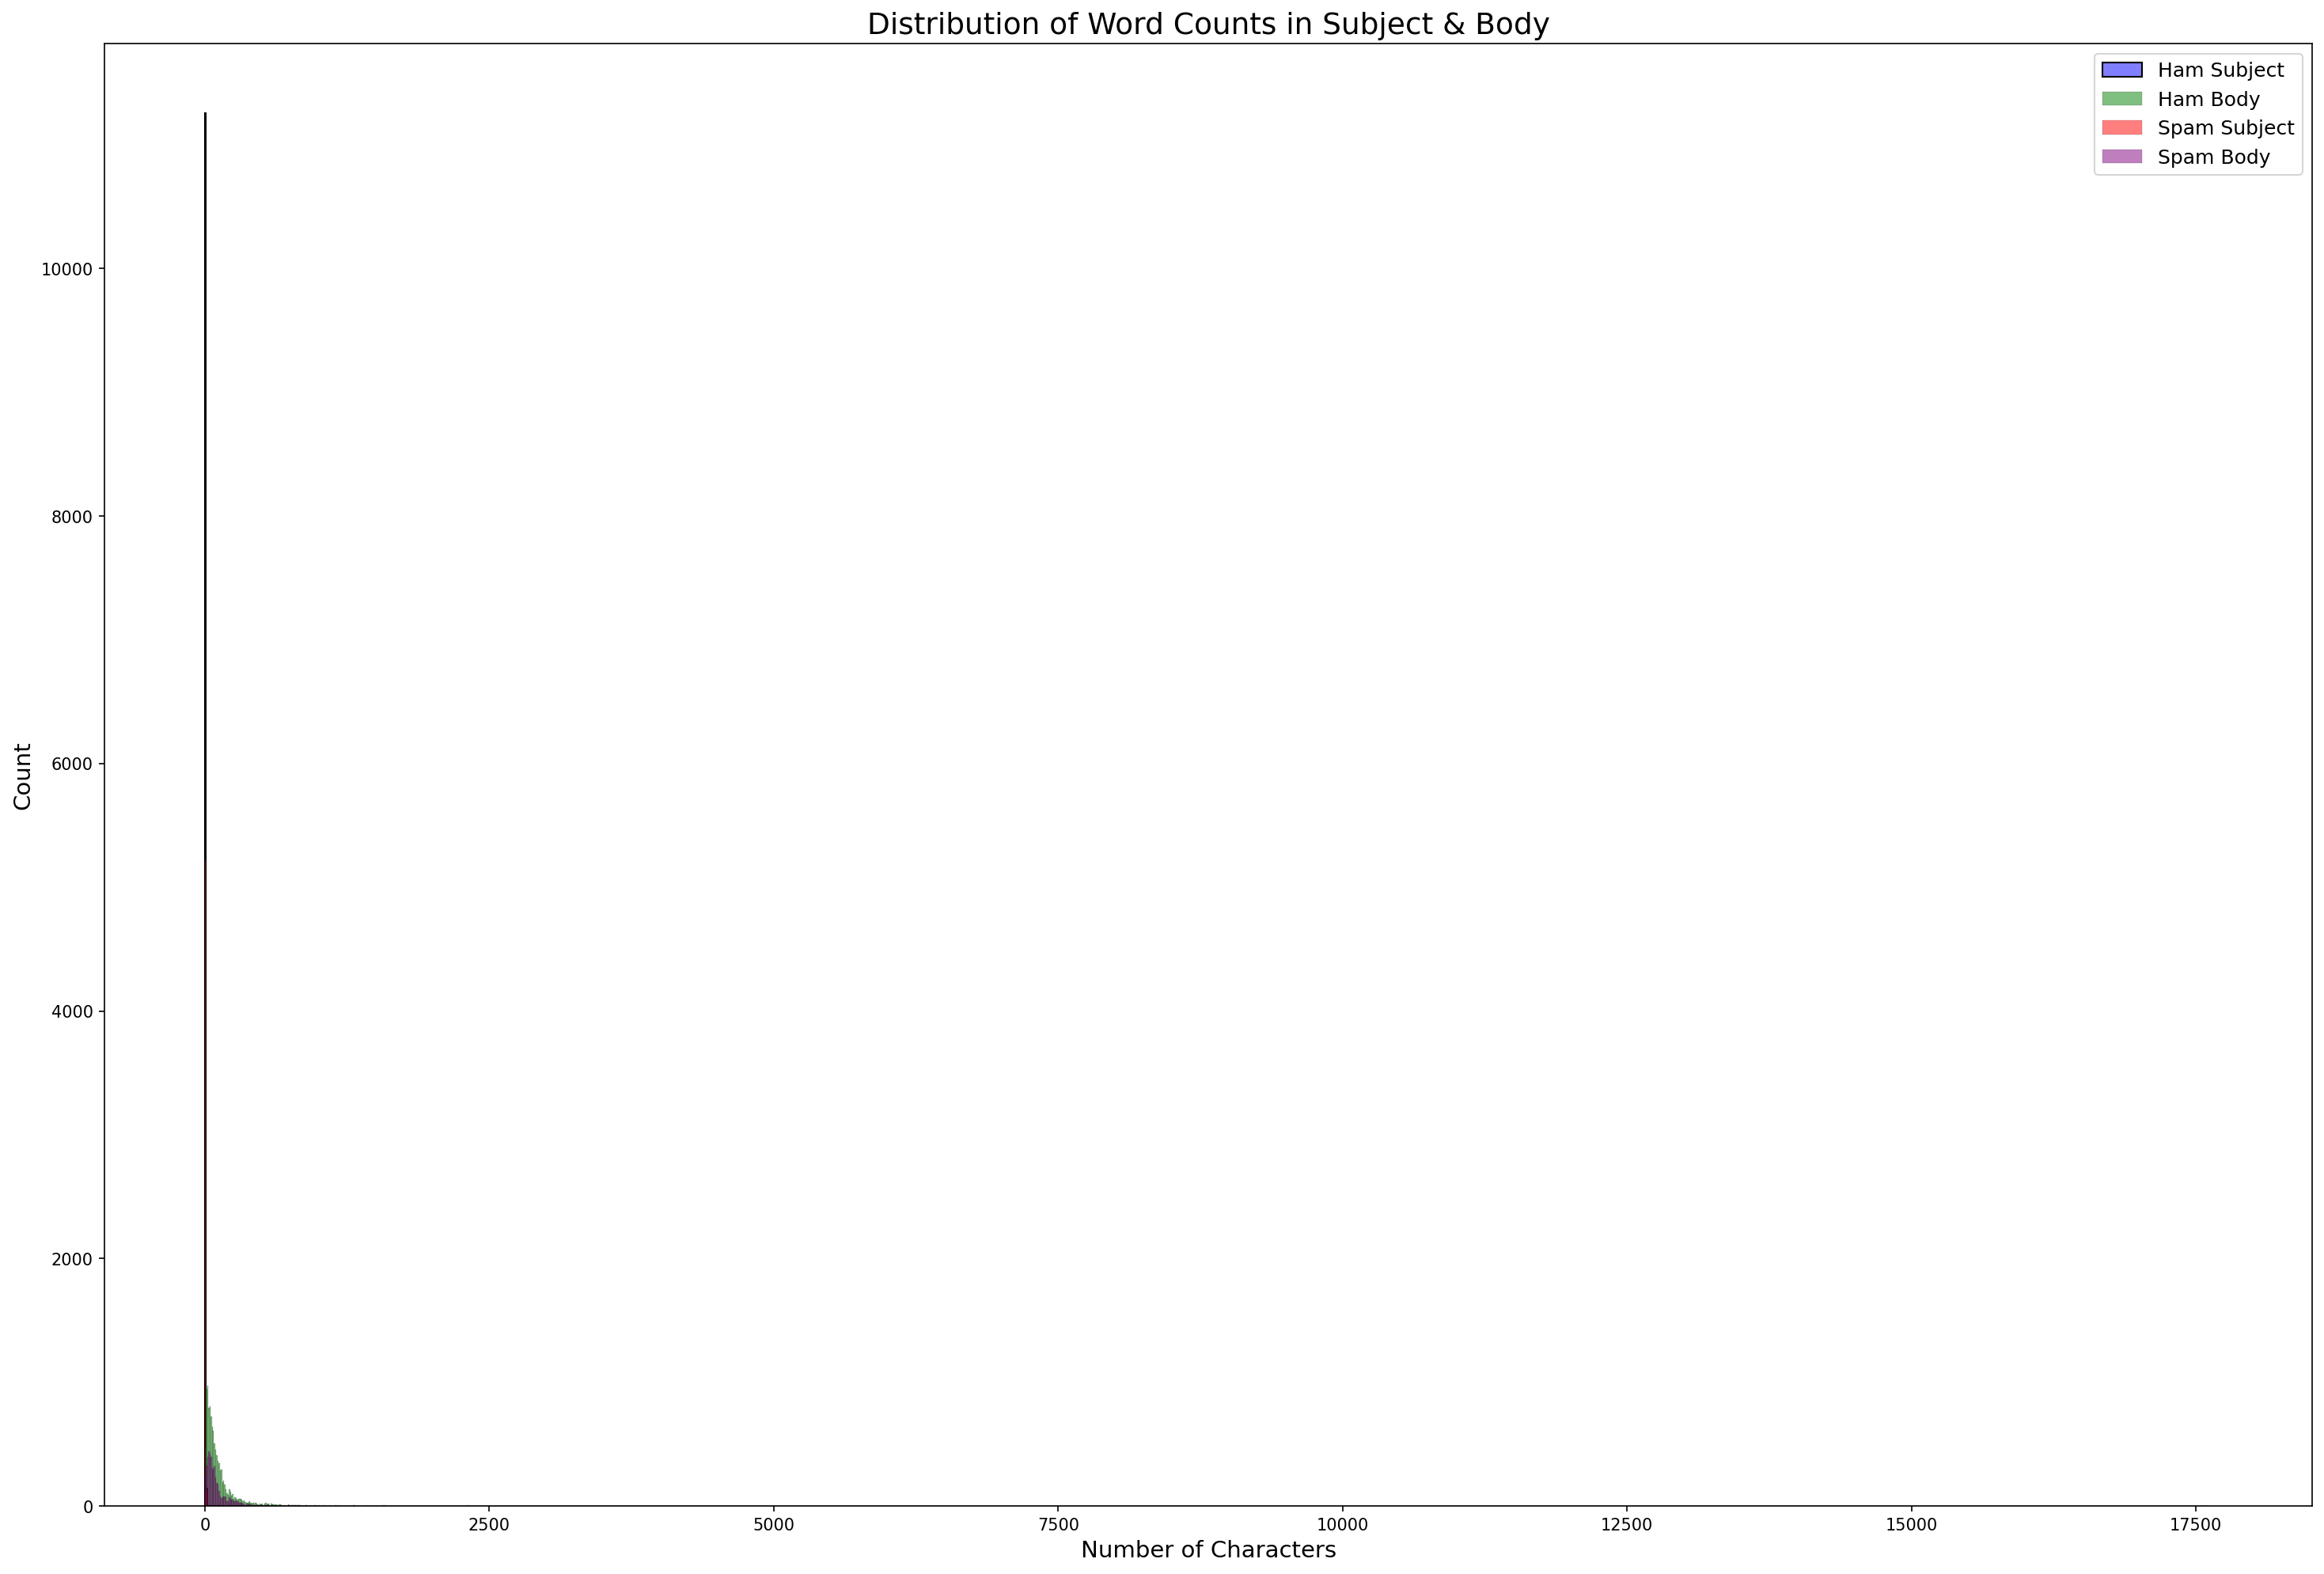

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 16),dpi=150)

# Ham (label = 0) - Subject & Body
sns.histplot(email_df[email_df['label'] == 0]['num_words_subject'], 
             color='blue', alpha=0.5, binwidth=10, label="Ham Subject")
sns.histplot(email_df[email_df['label'] == 0]['num_words_body'], 
             color='green', alpha=0.5, binwidth=10, label="Ham Body")

# Spam (label = 1) - Subject & Body
sns.histplot(email_df[email_df['label'] == 1]['num_words_subject'], 
             color='red', alpha=0.5, binwidth=10, label="Spam Subject")
sns.histplot(email_df[email_df['label'] == 1]['num_words_body'], 
             color='purple', alpha=0.5, binwidth=10, label="Spam Body")

# Titles & Labels
plt.title("Distribution of Word Counts in Subject & Body", fontsize=18)
plt.xlabel("Number of Characters", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(fontsize=12)  # Add legend for clarity

plt.show()


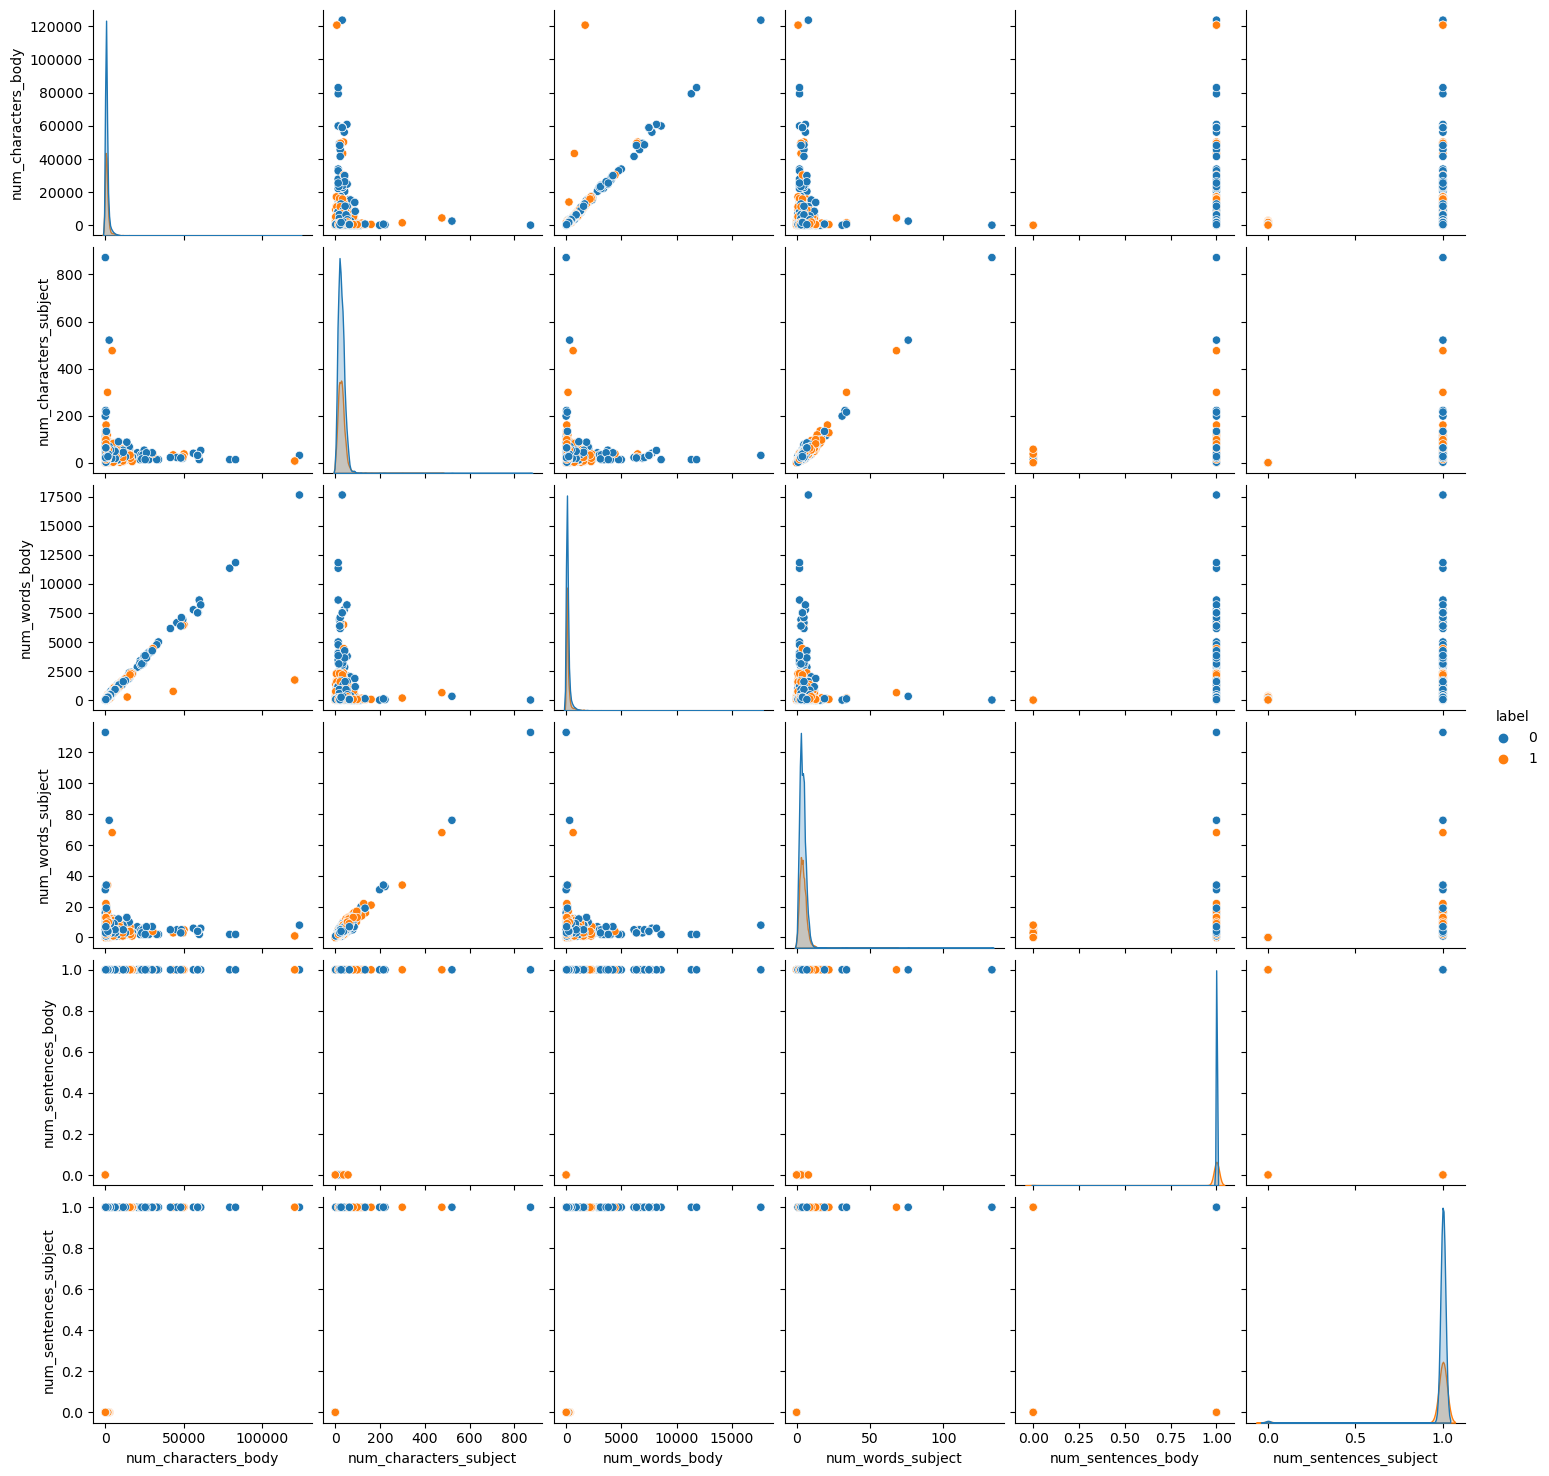

In [27]:
sns.pairplot(email_df,hue='label')
plt.show()

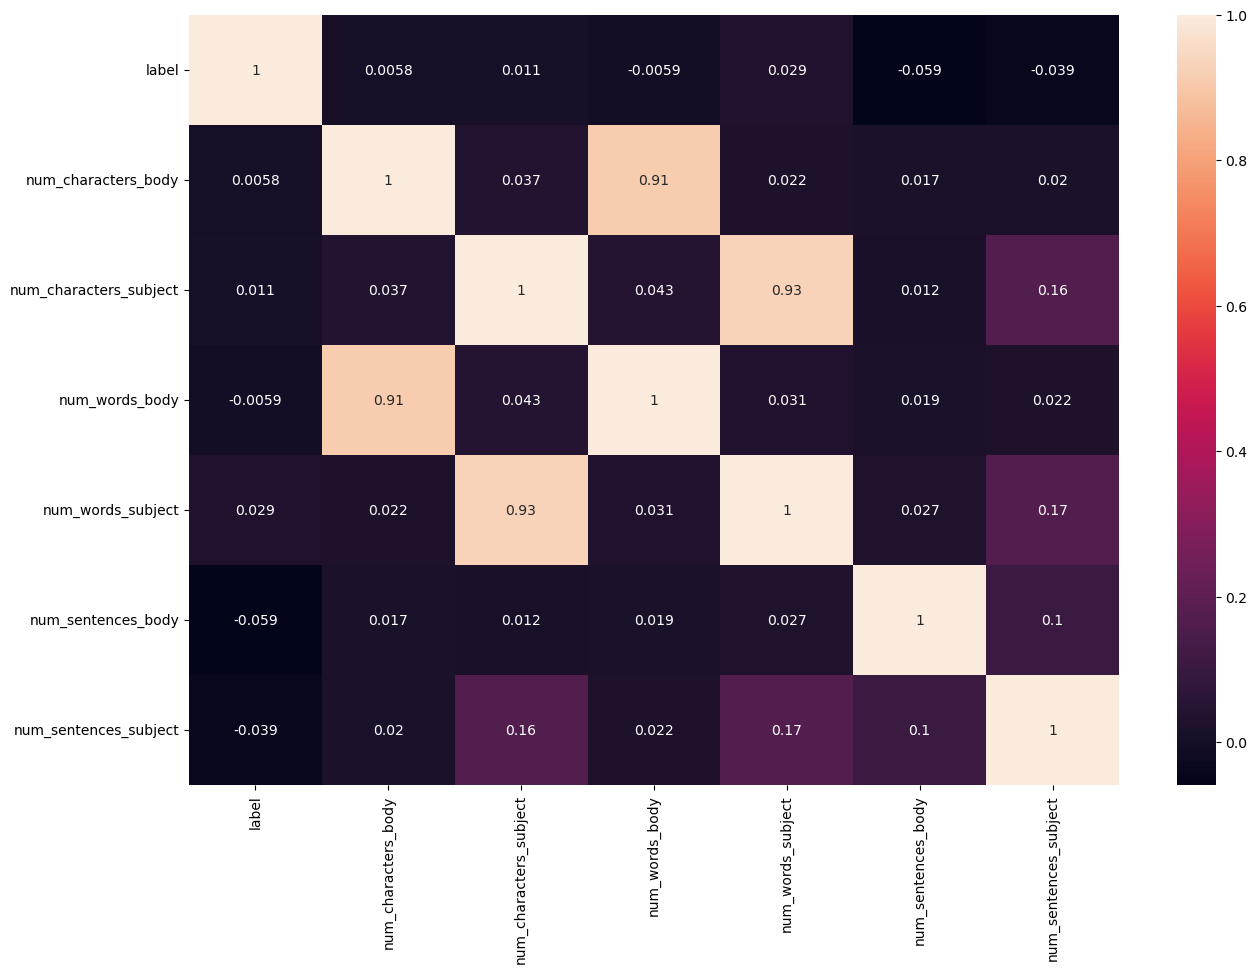

In [28]:
numeric_df = email_df.select_dtypes(include=[float, int])
plt.figure(figsize=(15,10))
sns.heatmap(numeric_df.corr(), annot=True)
plt.show()

In [29]:
email_df.head(10)

,subject,from,to,date,body,label,preprocessed_subject,preprocessed_body,num_characters_body,num_characters_subject,num_words_body,num_words_subject,num_sentences_body,num_sentences_subject
0,"ec 335 , ei 305 and smi 23 revision effective ...",NaN,NaN,NaN,p / l )\n- - - - - - - - - - - - - - - - - - -...,0,ec 335 ei 305 smi 23 revision effective 10 00 ...,forwarded ami chokshi corp enron 06 08 2000 06...,283,55,58,12,1,1
1,Re: [Razor-users] Razor with sendmail,Theo Van Dinter <felicity@kluge.net>,Sven Willenberger <sven@dmv.com>,"Fri, 23 Aug 2002 16:26:18 -0400","On Fri, Aug 23, 2002 at 04:17:55PM -0400, Sven...",0,razorusers razor sendmail,fri aug 23 2002 041755pm 0400 sven willenberge...,442,25,63,3,1,1
2,e - commerce & continental europe,NaN,NaN,NaN,"hi sven ,\nthanks a lot for your note - i thin...",0,commerce continental europe,hi sven thanks lot note think would great see ...,1330,27,185,3,1,1
3,Play by Play: Effective Memory Management,guardian <rssfeeds@example.com>,yyyy@example.com,"Thu, 26 Sep 2002 15:29:31 -0000","URL: http://www.newsisfree.com/click/-6,650303...",0,play play effective memory management,url date 20020803t0811170100 back 64kb memory ...,315,37,46,5,1,1
4,Re: [SAtalk] O.T. Habeus -- Why?,bob@proulx.com,Spamassassin-Talk <spamassassin-talk@example.s...,"Thu, 29 Aug 2002 10:32:57 -0600",Justin Mason <jm@jmason.org> [2002-08-29 17:00...,0,satalk ot habeus,justin mason 20020829 170012 0100 well point a...,502,16,74,3,1,1
5,Robbie Williams signs £80m deal,guardian <rssfeeds@example.com>,yyyy@example.com,"Thu, 03 Oct 2002 08:02:12 -0000","URL: http://www.newsisfree.com/click/215,8,215...",0,robbie williams sign 80m deal,url date 20021003t0420590100 art robbie willia...,85,29,12,5,1,1
6,info missing medical detaiis found 24 th march,NaN,NaN,NaN,stop\nthe protesters were also calling for an ...,1,info missing medical detaiis found 24 th march,stop protester also calling international inve...,4991,46,597,8,1,1
7,RE: [ILUG] slashdot EW Dijkstra humor,Kenn Humborg <kenn@bluetree.ie>,"Nick Murtagh <nickm@go2.ie>, ilug@linux.ie","Mon, 12 Aug 2002 19:56:23 +0100",> > If you're using a break or similar constru...,0,ilug slashdot ew dijkstra humor,youre using break similar construct loop might...,392,31,55,5,1,1
8,[ILUG] Create a PAYCHECK with your COMPUTER an...,Hugh5546x73@bigfoot.com,ilug@linux.ie,"Tue, 24 Sep 2002 01:31:44 +1200",Hi -\n\n( http://club.4tfox.com )\n\nYou get e...,1,ilug create paycheck computer enjoy cheap isp ...,hi get email every day offering show make mone...,1714,63,254,9,1,1
9,Re: It's a small world,Luis Villa <louie@ximian.com>,Jesse <jesse@fsck.com>,"Thu, 15 Aug 2002 18:01:06 -0400","On Thu, 2002-08-15 at 17:53, Jesse wrote:\n> \...",0,small world,thu 20020815 1753 jesse wrote thu aug 15 2002 ...,584,11,85,2,1,1


In [29]:
spam_corpus = []
for msg in email_df[email_df['label'] == 1]['preprocessed_body'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [30]:
len(spam_corpus)

787242

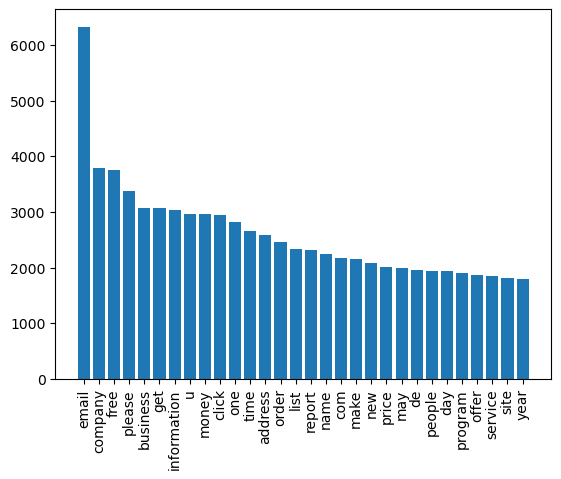

<Figure size 3000x2000 with 0 Axes>

In [31]:
from collections import Counter
plt.bar(pd.DataFrame(Counter(spam_corpus).most_common(30))[0],pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.figure(figsize=(30,20))
plt.show()

In [32]:
ham_corpus = []
for msg in email_df[email_df['label'] == 0]['preprocessed_body'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

In [33]:
len(ham_corpus)

1730758

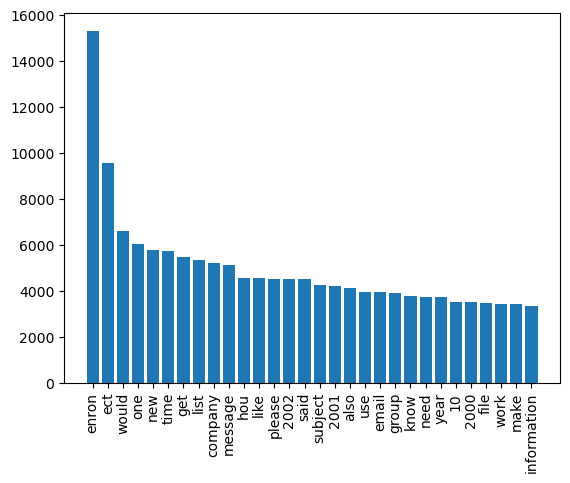

In [34]:
from collections import Counter
plt.bar(pd.DataFrame(Counter(ham_corpus).most_common(30))[0],pd.DataFrame(Counter(ham_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

In [35]:
def save_corpora(spam_corpus, ham_corpus):
    """Save existing spam and ham corpora to files"""
    try:
        # Convert lists to space-separated strings
        spam_text = ' '.join(spam_corpus)
        ham_text = ' '.join(ham_corpus)
        
        # Save to files
        with open('spam_corpus_email.txt', 'w', encoding='utf-8') as f:
            f.write(spam_text)
        
        with open('ham_corpus_email.txt', 'w', encoding='utf-8') as f:
            f.write(ham_text)
            
        return True
    except Exception as e:
        print(f"Error saving corpora: {e}")
        return False

# Usage
save_corpora(spam_corpus, ham_corpus)

True

In [36]:
X_subject.shape

(16754, 1000)

In [37]:
X_body.shape

(16754, 5000)

In [38]:
X_combined.shape

(16754, 6000)

In [39]:
# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_combined,email_df['label'],test_size=0.2, random_state=42)


In [40]:
y = email_df['label'].values
y

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [41]:
from sklearn.metrics import confusion_matrix

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)


In [43]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB

In [44]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [48]:
mnb.fit(X_train,y_train)
y_pred = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(precision_score(y_test,y_pred))
print(specificity_score(y_test,y_pred))

0.9656818860041778
[[2243   55]
 [  60  993]]
0.9475190839694656
0.9760661444734552


In [49]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))
print(specificity_score(y_test,y_pred1))

0.9456878543718293
[[2154  144]
 [  38 1015]]
0.8757549611734253
0.9373368146214099


In [50]:
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(precision_score(y_test,y_pred3))
print(specificity_score(y_test,y_pred3))

0.9689644882124739
[[2249   49]
 [  55  998]]
0.9531996179560649
0.9786771105308965


In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [100]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [101]:
clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [102]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    specificity = specificity_score(y_test,y_pred)
    return accuracy,precision,specificity

In [103]:
train_classifier(svc,X_train,y_train,X_test,y_test)

(0.9716502536556252, 0.9476635514018692, 0.9756309834638817)

In [104]:
accuracy_scores = []
precision_scores = []
specificity_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision,current_specificity = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    print("Specificity - ",current_specificity)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    specificity_scores.append(current_specificity)

For  SVC
Accuracy -  0.9716502536556252
Precision -  0.9476635514018692
Specificity -  0.9756309834638817
For  KN
Accuracy -  0.709340495374515
Precision -  0.5198992443324937
Specificity -  0.5852915578764143
For  NB
Accuracy -  0.9656818860041778
Precision -  0.9475190839694656
Specificity -  0.9760661444734552
For  DT
Accuracy -  0.8463145329752313
Precision -  0.8909883720930233
Specificity -  0.9673629242819843
For  LR
Accuracy -  0.9752312742464936
Precision -  0.9490740740740741
Specificity -  0.9760661444734552
For  RF
Accuracy -  0.979707549985079
Precision -  0.9650613786591123
Specificity -  0.983899042645779
For  AdaBoost
Accuracy -  0.9310653536257834
Precision -  0.8518835616438356
Specificity -  0.9247171453437772
For  BgC
Accuracy -  0.9695613249776186
Precision -  0.9515669515669516
Specificity -  0.9778067885117493
For  ETC
Accuracy -  0.9823933154282304
Precision -  0.9724334600760456
Specificity -  0.9873803307223673
For  GBDT
Accuracy -  0.9009250969859743
Precisio

In [105]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores,'Specificty':specificity_scores}).sort_values('Precision',ascending=False)

In [106]:
performance_df

,Algorithm,Accuracy,Precision,Specificty
8,ETC,0.982393,0.972433,0.987380
5,RF,0.979708,0.965061,0.983899
7,BgC,0.969561,0.951567,0.977807
4,LR,0.975231,0.949074,0.976066
0,SVC,0.971650,0.947664,0.975631
2,NB,0.965682,0.947519,0.976066
9,GBDT,0.900925,0.946716,0.981288
10,xgb,0.973142,0.946247,0.974761
3,DT,0.846315,0.890988,0.967363
6,AdaBoost,0.931065,0.851884,0.924717


In [107]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")

In [108]:
performance_df1

,Algorithm,variable,value
0,ETC,Accuracy,0.982393
1,RF,Accuracy,0.979708
2,BgC,Accuracy,0.969561
3,LR,Accuracy,0.975231
4,SVC,Accuracy,0.971650
5,NB,Accuracy,0.965682
6,GBDT,Accuracy,0.900925
7,xgb,Accuracy,0.973142
8,DT,Accuracy,0.846315
9,AdaBoost,Accuracy,0.931065


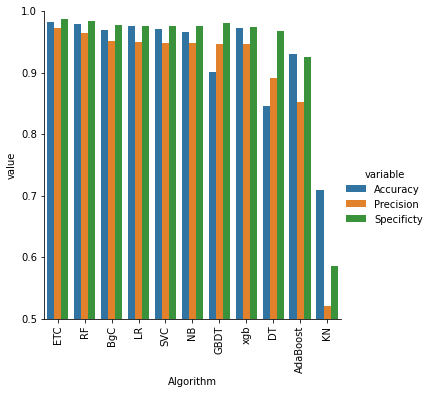

In [109]:
sns.catplot(x = 'Algorithm', y='value', 
               hue = 'variable',data=performance_df1, kind='bar',height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

In [110]:
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_max_ft_3000':accuracy_scores,'Precision_max_ft_3000':precision_scores,'Specificity_max_ft_3000':specificity_scores}).sort_values('Precision_max_ft_3000',ascending=False)

In [111]:
temp_df

,Algorithm,Accuracy_max_ft_3000,Precision_max_ft_3000,Specificity_max_ft_3000
8,ETC,0.982393,0.972433,0.987380
5,RF,0.979708,0.965061,0.983899
7,BgC,0.969561,0.951567,0.977807
4,LR,0.975231,0.949074,0.976066
0,SVC,0.971650,0.947664,0.975631
2,NB,0.965682,0.947519,0.976066
9,GBDT,0.900925,0.946716,0.981288
10,xgb,0.973142,0.946247,0.974761
3,DT,0.846315,0.890988,0.967363
6,AdaBoost,0.931065,0.851884,0.924717


In [112]:
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_scaling':accuracy_scores,'Precision_scaling':precision_scores,'Specificity_scaling': specificity_scores}).sort_values('Precision_scaling',ascending=False)

In [113]:
temp_df

,Algorithm,Accuracy_scaling,Precision_scaling,Specificity_scaling
8,ETC,0.982393,0.972433,0.987380
5,RF,0.979708,0.965061,0.983899
7,BgC,0.969561,0.951567,0.977807
4,LR,0.975231,0.949074,0.976066
0,SVC,0.971650,0.947664,0.975631
2,NB,0.965682,0.947519,0.976066
9,GBDT,0.900925,0.946716,0.981288
10,xgb,0.973142,0.946247,0.974761
3,DT,0.846315,0.890988,0.967363
6,AdaBoost,0.931065,0.851884,0.924717


In [114]:
new_df = performance_df.merge(temp_df,on='Algorithm')

In [115]:
new_df_scaled = new_df.merge(temp_df,on='Algorithm')

In [116]:
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_num_chars':accuracy_scores,'Precision_num_chars':precision_scores,'Precision_num_chars':specificity_scores}).sort_values('Precision_num_chars',ascending=False)

In [117]:
new_df_scaled.merge(temp_df,on='Algorithm')

,Algorithm,Accuracy,Precision,Specificty,Accuracy_scaling_x,Precision_scaling_x,Specificity_scaling_x,Accuracy_scaling_y,Precision_scaling_y,Specificity_scaling_y,Accuracy_num_chars,Precision_num_chars
0,ETC,0.982393,0.972433,0.987380,0.982393,0.972433,0.987380,0.982393,0.972433,0.987380,0.982393,0.987380
1,RF,0.979708,0.965061,0.983899,0.979708,0.965061,0.983899,0.979708,0.965061,0.983899,0.979708,0.983899
2,BgC,0.969561,0.951567,0.977807,0.969561,0.951567,0.977807,0.969561,0.951567,0.977807,0.969561,0.977807
3,LR,0.975231,0.949074,0.976066,0.975231,0.949074,0.976066,0.975231,0.949074,0.976066,0.975231,0.976066
4,SVC,0.971650,0.947664,0.975631,0.971650,0.947664,0.975631,0.971650,0.947664,0.975631,0.971650,0.975631
5,NB,0.965682,0.947519,0.976066,0.965682,0.947519,0.976066,0.965682,0.947519,0.976066,0.965682,0.976066
6,GBDT,0.900925,0.946716,0.981288,0.900925,0.946716,0.981288,0.900925,0.946716,0.981288,0.900925,0.981288
7,xgb,0.973142,0.946247,0.974761,0.973142,0.946247,0.974761,0.973142,0.946247,0.974761,0.973142,0.974761
8,DT,0.846315,0.890988,0.967363,0.846315,0.890988,0.967363,0.846315,0.890988,0.967363,0.846315,0.967363
9,AdaBoost,0.931065,0.851884,0.924717,0.931065,0.851884,0.924717,0.931065,0.851884,0.924717,0.931065,0.924717


## Takes too much time

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

grid_search = GridSearchCV(
    SVC(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit the grid search
grid_search.fit(X_combined, email_df['label'])

# Get the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


## ----------------

In [46]:
from sklearn.ensemble import VotingClassifier
# Voting Classifier
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

In [48]:
voting = VotingClassifier(estimators=[('etc', etc), ('rf', rfc), ('bgc', bc)],voting='soft')

In [49]:
voting.fit(X_train,y_train)

VotingClassifier(estimators=[('etc',
                              ExtraTreesClassifier(n_estimators=50,
                                                   random_state=2)),
                             ('rf',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=2)),
                             ('bgc',
                              BaggingClassifier(n_estimators=50,
                                                random_state=2))],
                 voting='soft')

In [54]:
from sklearn.metrics import recall_score 

y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))
print("Recall", recall_score(y_test,y_pred))
print("F1-Score", f1_score(y_test,y_pred))
print("Specificity", specificity_score(y_test,y_pred))

Accuracy 0.979707549985079
Precision 0.966824644549763
Recall 0.9686609686609686
F1-Score 0.967741935483871
Specificity 0.984769364664926


## For CPU

In [76]:
# Applying stacking
estimators=[('etc', etc), ('rf', rfc), ('bgc', bc)]
final_estimator=RandomForestClassifier()

In [77]:
from sklearn.ensemble import StackingClassifier
stk_model_cpu = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [78]:
stk_model_cpu.fit(X_train,y_train)
y_pred = stk_model_cpu.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))
print("Specificity",specificity_score(y_test,y_pred))

Accuracy 0.9814980602805132
Precision 0.9661335841956726
Specificity 0.9843342036553525


In [82]:
import pickle
pickle.dump(subject_vectorizer,open('./stacking_mod_u_cpu/subject_vectorizer.pkl','wb'))
pickle.dump(body_vectorizer,open('./stacking_mod_u_cpu/body_vectorizer.pkl','wb'))
pickle.dump(stk_model_cpu,open('./stacking_mod_u_cpu/stacking_model_cpu.pkl','wb'))

## For GPU

In [65]:
from lightgbm import LGBMClassifier

estimators=[('etc', etc), ('rf', rfc), ('bgc', bc)]
final_estimator=XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, tree_method='gpu_hist', gpu_id=0)

In [74]:
from sklearn.ensemble import StackingClassifier
stk_model = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [67]:
stk_model.fit(X_train,y_train)
y_pred = stk_model.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))
print("Specificity",specificity_score(y_test,y_pred))

/home/user-1/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:16:53] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/home/user-1/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:16:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Accuracy 0.9832885705759474
Precision 0.9645852749301025
Specificity 0.9834638816362054


/home/user-1/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:17:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/user-1/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:17:02] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [68]:
import pickle
pickle.dump(subject_vectorizer,open('subject_vectorizer.pkl','wb'))
pickle.dump(body_vectorizer,open('body_vectorizer.pkl','wb'))
pickle.dump(stk_model,open('stacking_model.pkl','wb'))

## Best Overall result Tensorflow(Both CPU and GPU can be used)

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True)

model.fit(X_train,
          y_train, 
          epochs=50, 
          batch_size=32, 
          validation_data=(X_test, y_test),
          callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy}')

y_pred = (model.predict(X_test) > 0.5).astype("int32")

precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Precision: {precision}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')

C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8779 - loss: 0.2819 - val_accuracy: 0.9824 - val_loss: 0.0475
Epoch 2/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9953 - loss: 0.0152 - val_accuracy: 0.9842 - val_loss: 0.0510
Epoch 3/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9992 - loss: 0.0041 - val_accuracy: 0.9872 - val_loss: 0.0462
Epoch 4/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9875 - val_loss: 0.0485
Epoch 5/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9998 - loss: 6.7837e-04 - val_accuracy: 0.9875 - val_loss: 0.0522
Epoch 6/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 3.2293e-04 - val_accuracy: 0.9866 - val_loss: 0.0555
Epoch 7/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9998 - loss: 4.6181e-04 - val_accuracy: 0.9869 - val_loss: 0.0577
Epoch 8/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 1.0846e-04 - 

In [47]:
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)
specificity = specificity_score(y_test,y_pred)

print(f'Recall: {recall}')
print(f'Specificity: {specificity}')

Recall: 0.976258309591643
Specificity: 0.9921671018276762


In [51]:
from tensorflow.keras.models import load_model as tfk__load_model

model.save('ann_model.keras')

In [56]:
model = tf.keras.models.load_model('ann_model.h5')

In [48]:
from collections import Counter

# Assuming spam_corpus is a list of words
word_counts = Counter(spam_corpus)

# Get the 30 most common words
most_common_words = word_counts.most_common(30)

# Print each word with its frequency
for word, freq in most_common_words:
    print(f"{word}: {freq}")

email: 6325
company: 3787
free: 3747
please: 3379
business: 3075
get: 3063
information: 3032
u: 2972
money: 2971
click: 2945
one: 2820
time: 2659
address: 2586
order: 2455
list: 2337
report: 2313
name: 2238
com: 2171
make: 2160
new: 2091
price: 2004
may: 2001
de: 1956
people: 1944
day: 1942
program: 1896
offer: 1869
service: 1846
site: 1818
year: 1787
